This notebook is to predict the HOMO-LUMO gap for 100,000 molecules with a 3D point cloud using the XConv layer.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan 31 19:54:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              52W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# PyG installation

In [3]:
# install
!pip install torch_geometric

# Optional dependencies:
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu121.html

  Using cached torch_geometric-2.4.0-py3-none-any.whl (1.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 34.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
  Using cached https://data.pyg.org/whl/torch-2.1.0%2Bcu121/torch_scatter-2.1.2%2Bpt21cu121-cp310-cp310-linux_x86_64.whl (10.8 MB)
  Using cached https://data.pyg.org/whl/torch-2.1.0%2Bcu121/torch_sparse-0.6.18%2Bpt21cu121-cp310-cp310-linux_x86_64.whl (5.0 MB)
  Using cached https://data.pyg.org/

# RDKit installation

In [4]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [5]:
condacolab.check()

✨🍰✨ Everything looks OK!


In [6]:
!conda install -c conda-forge rdkit

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / failed with initial frozen solve. Retrying with flexible solve.
Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | 

# Load modules and data set

In [7]:
import rdkit
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem

import torch
import torch_geometric
from torch_geometric.data import Data

import numpy as np
import pandas as pd
import joblib

In [8]:
pubchem = pd.read_csv("https://www.dropbox.com/s/stxhvcgk0kvs89m/PubchemQC_HOMO-LUMO_100000.csv?dl=1")

In [9]:
pubchem

,#Index,HOMO-LUMO_gap(eV),Oscillator_Strength,SMILES
0,1,4.015,0.002,CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C
1,2,5.758,0.000,CC(=O)OC(CC(=O)O)C[N+](C)(C)C
2,3,4.039,0.053,C1=CC(C(C(=C1)C(=O)O)O)O
3,4,5.596,0.004,CC(CN)O
4,5,4.278,0.001,C(C(=O)COP(=O)(O)O)N
...,...,...,...,...
99994,303049,4.282,0.092,COC(C1=CC=CC2=CC=CC=C21)C(=O)O
99995,303051,5.805,0.005,CCS(=O)(=O)N1CCCCC1C
99996,303052,5.891,0.019,CCN(CC)S(=O)(=O)CC
99997,303053,5.876,0.006,CCCN(CCC)S(=O)(=O)CC


We will use the molecules consisting of H, B, C, N, O, F, P, S, and Cl ony.

In [10]:
# check the molecules that meet the requirement for atomic compositions
def check_atoms(mol):
  """
  This function checks whether all atoms are valid
  """
  valid_atoms = ('H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl')
  flag = True
  for atm in mol.GetAtoms():       # for loop: atoms in the molecules
    if atm.GetSymbol() not in valid_atoms:
      flag = False
      break
  return flag

In [11]:
from tqdm import tqdm
homo_lumo_data = []
for smi, score in tqdm(zip(pubchem['SMILES'], pubchem['HOMO-LUMO_gap(eV)'])):
  mol = Chem.MolFromSmiles(smi)
  if check_atoms(mol):
    homo_lumo_data.append((Chem.MolFromSmiles(smi), score))
  else:
    continue

314it [00:00, 3131.49it/s][19:57:55] WARNING: not removing hydrogen atom without neighbors
[19:57:55] WARNING: not removing hydrogen atom without neighbors
16387it [00:06, 2517.05it/s][19:58:01] WARNING: not removing hydrogen atom without neighbors
[19:58:01] WARNING: not removing hydrogen atom without neighbors
41901it [00:14, 2917.30it/s][19:58:10] WARNING: not removing hydrogen atom without neighbors
[19:58:10] WARNING: not removing hydrogen atom without neighbors
99999it [00:37, 2676.52it/s]


# Graph representation of molecules

In [12]:
def convert_mol_to_graph(mol, use_pos = False):

  mol2 = Chem.AddHs(mol)                      # add hydrogens
  n_bonds = len(mol2.GetBonds())              # the number of covalent bonds
  n_atoms = len(mol2.GetAtoms())              # the number of atoms

  ## calculate the edge attributes and weights
  edge_index = []
  edge_attr = []
  edge_weight = []

  for idx in range(n_bonds):                  # 'for loop' for entire bonds
    bond = mol2.GetBondWithIdx(idx)           # get a bond index for each bond
    edge_index.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])   # save a list of begin and end atom indices for each covalent bond
    edge_index.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])   # the opposite direction as it's undirected graphs

    # bond type (4-dimensional one-hot)
    btype = bond.GetBondType()                # types of bonds
    if btype == Chem.rdchem.BondType.SINGLE:  # single bond
      bond_one_hot = [1, 0, 0, 0]             # for edge_attr: one-hot encoding for bond types
      edge_weight.extend([1.0, 1.0])          # for edge_weight: 1 for single bonds
    elif btype == Chem.rdchem.BondType.AROMATIC:    # aromatic bond
      bond_one_hot = [0, 1, 0, 0]
      edge_weight.extend([1.5, 1.5])
    elif btype == Chem.rdchem.BondType.DOUBLE:      # double bond
      bond_one_hot = [0, 0, 1, 0]
      edge_weight.extend([2.0, 2.0])
    elif btype == Chem.rdchem.BondType.TRIPLE:      # triple bond
      bond_one_hot = [0, 0, 0, 1]
      edge_weight.extend([3.0, 3.0])

    # bond stereo (6-dimensional one-hot)
    stype = bond.GetStereo()
    if stype == Chem.rdchem.BondStereo.STEREOANY:
      stereo_one_hot = [1, 0, 0, 0, 0, 0]
    elif stype == Chem.rdchem.BondStereo.STEREOCIS:
      stereo_one_hot = [0, 1, 0, 0, 0, 0]
    elif stype == Chem.rdchem.BondStereo.STEREOE:
      stereo_one_hot = [0, 0, 1, 0, 0, 0]
    elif stype == Chem.rdchem.BondStereo.STEREONONE:
      stereo_one_hot = [0, 0, 0, 1, 0, 0]
    elif stype == Chem.rdchem.BondStereo.STEREOTRANS:
      stereo_one_hot = [0, 0, 0, 0, 1, 0]
    elif stype == Chem.rdchem.BondStereo.STEREOZ:
      stereo_one_hot = [0, 0, 0, 0, 0, 1]

    # does this bond include a ring?
    if bond.IsInRing():
      ring_bond = 1
    else:
      ring_bond = 0

    # is this bond a conjugates bond?
    if bond.GetIsConjugated():
      conjugate = 1
    else:
      conjugate = 0

    # total 12-dimensional edge attributes
    # bond-type (4-dim), bondstereo (6-dim), ring? (1-dim), conjugate? (1-dim)
    attr = bond_one_hot + stereo_one_hot + [ring_bond, conjugate]

    edge_attr.append(attr)
    edge_attr.append(attr)      # append two times as it's an undirected graph
  ## complete the edge attributes and weights


  ## calculate the node features
  # refer to this link, https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Atom
  #        0.   1.   2.   3.   4.   5.   6.   7.   8.
  #       'H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl'
  valid_atoms = {'H':0, 'B':1, 'C':2, 'N':3, 'O':4, 'F':5, 'P':6, 'S':7, 'Cl':8}
  node_attr = []

  for atm_id in range(n_atoms):
    # select an atom
    atm = mol2.GetAtomWithIdx(atm_id)

    # atom symbol check (9-dim)
    sym = atm.GetSymbol()
    atm_one_hot = [0] * len(valid_atoms)  # make a list consisting of nine zeros
    idx = valid_atoms[sym]                # check what the element is
    atm_one_hot[idx] = 1                  # change to one from zero for the element

    # check hybridization (7-dim)
    hybrid = atm.GetHybridization()
    hybrid_one_hot = [0] * 7              # make a list consisting of nine zeros
    if hybrid == Chem.HybridizationType.SP3:
      hybrid_one_hot[0] == 1
    elif hybrid == Chem.HybridizationType.SP2:
      hybrid_one_hot[1] = 1
    elif hybrid == Chem.HybridizationType.SP:
      hybrid_one_hot[2] = 1
    elif hybrid == Chem.HybridizationType.S:
      hybrid_one_hot[3] = 1
    elif hybrid == Chem.HybridizationType.SP3D:
      hybrid_one_hot[4] = 1
    elif hybrid == Chem.HybridizationType.SP3D2:
      hybrid_one_hot[5] = 1
    else: # all other cases
      hybrid_one_hot[6] = 1

    # check aromaticity: 0 or 1
    if atm.GetIsAromatic():
      arom = 1
    else:
      arom = 0

    # ring?
    if atm.IsInRing():
      ring_flag = 1
    else:
      ring_flag = 0

    # degree (the number of covalent bonds) (6-dimensional one-hot)
    # 0, 1, 2, 3, 4, >=5
    degree_one_hot = [0] * 6
    degree = atm.GetTotalDegree()
    if degree >= 5:
      degree_one_hot[5] = 1
    else:
      degree_one_hot[degree] = 1

    # the number of hydrogen bonded (5-dim, one-hot)
    # 0, 1, 2, 3, >=4
    num_h = atm.GetTotalNumHs()
    hydrogen_one_hot = [0] * 5
    if num_h >= 4:
      hydrogen_one_hot[4] = 1
    else:
      hydrogen_one_hot[num_h] = 1

    # chirality (4-dimensional one-hot)
    chiral = atm.GetChiralTag()
    if chiral == Chem.rdchem.ChiralType.CHI_OTHER:
      chiral_one_hot = [1, 0, 0, 0]
    elif chiral == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW:    # couter-clockwise
      chiral_one_hot = [0, 1, 0, 0]
    elif chiral == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW:     # clockwise
      chiral_one_hot = [0, 0, 1, 0]
    elif chiral == Chem.rdchem.ChiralType.CHI_UNSPECIFIED:        # chirality not defined
      chiral_one_hot = [0, 0, 0, 1]

    # atomic feature calculation;
    # [atomic symbol one-hot, hybridization, aromaticity, ring, degree, # of hydrogen, chirality, formal charge, # of radical electrons]
    # 9 + 7 + 1 + 1 + 6 + 5 + 4 + 1 + 1 = 35 dimensions
    attr = atm_one_hot + hybrid_one_hot + degree_one_hot + hydrogen_one_hot + \
           chiral_one_hot + [arom, ring_flag, atm.GetFormalCharge(), atm.GetNumRadicalElectrons()]

    node_attr.append(attr)
  ## complete the node features

  # change the types of all node and edge features to pytorch tensors
  edge_attr = torch.tensor(edge_attr, dtype = torch.float)
  node_attr = torch.tensor(node_attr, dtype = torch.float)
  edge_index = torch.tensor(edge_index, dtype = torch.long)       # (2 * # of covalent bonds x 2)
  edge_index = edge_index.t().contiguous()                        # 2 x (2 * # of covalent bonds), shape change required for PyG operations
  edge_weight = torch.tensor(edge_weight, dtype = torch.float)    # one dimensional tensor (2 * # of bonds)

  if use_pos:               # if coordinates(=positional) information used
    val = AllChem.EmbedMolecule(mol2)     # EmbedMolecule: method for predicting the 3d structures of molecules
    if val != 0:
      print(f"Error while generating 3D: {Chem.MolToSmiles(mol)}")
      return None

    pos_list = []           # this is optional
    for atm_id in range(n_atoms):
      # get atomic positions
      atm_pos = mol2.GetConformer(0).GetAtomPosition(atm_id)
      crd = [atm_pos.x, atm_pos.y, atm_pos.z]
      pos_list.append(crd)

    pos = torch.tensor(pos_list, dtype = torch.float)
  else:
    pos = None

  return edge_index, node_attr, edge_attr, pos, edge_weight

In [13]:
edge_index, x, edge_attr, pos, edge_weight = convert_mol_to_graph(homo_lumo_data[0][0], use_pos=True)

In [14]:
d0 = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, pos=pos, edge_weight=edge_weight)

In [15]:
print(d0)

Data(x=[31, 35], edge_index=[2, 60], edge_attr=[60, 12], pos=[31, 3], edge_weight=[60])


In [16]:
d0.pos

tensor([[-2.4033, -2.8025,  0.0667],
        [-1.9749, -1.3711,  0.2567],
        [-2.3228, -0.7020,  1.2522],
        [-1.1667, -0.7190, -0.6707],
        [-0.7593,  0.6373, -0.4902],
        [-1.3623,  1.4329, -1.6052],
        [-1.1087,  2.8632, -1.6196],
        [-0.4852,  3.4508, -0.7252],
        [-1.5921,  3.6008, -2.6917],
        [ 0.7209,  0.7716, -0.4729],
        [ 1.3992,  0.0337,  0.5602],
        [ 1.6212, -1.3242,  0.0931],
        [ 2.7374,  0.6259,  0.7183],
        [ 0.7794,  0.0515,  1.8415],
        [-2.7934, -2.8828, -0.9597],
        [-1.5897, -3.4861,  0.2957],
        [-3.2405, -2.9773,  0.7838],
        [-1.1846,  0.9846,  0.4639],
        [-1.1385,  0.9655, -2.6150],
        [-2.4833,  1.2838, -1.4868],
        [ 1.1426,  0.4259, -1.4597],
        [ 1.0088,  1.8281, -0.3845],
        [ 1.3981, -2.0551,  0.8788],
        [ 1.0107, -1.5393, -0.8245],
        [ 2.6798, -1.4959, -0.2316],
        [ 3.4244, -0.1400,  1.1082],
        [ 3.0856,  1.0772, -0.2481],
 

# Transformation into PyG data type

In [17]:
data_list = []
for mol, score in tqdm(homo_lumo_data):
  result = convert_mol_to_graph(mol, use_pos=True)
  if result is None:
    continue

  edge_index, node_attr, edge_attr, pos, edge_weight = result
  y = torch.tensor([[score]], dtype=torch.float)
  dtmp = Data(x = node_attr, pos = pos, edge_index = edge_index, edge_attr = edge_attr, edge_weight = edge_weight, y = y)
  data_list.append(dtmp)

  1%|          | 806/99999 [00:13<33:53, 48.79it/s][20:20:24] UFFTYPER: Unrecognized charge state for atom: 1
[20:20:24] UFFTYPER: Unrecognized charge state for atom: 1
[20:20:24] UFFTYPER: Unrecognized charge state for atom: 1
  7%|▋         | 6801/99999 [03:36<34:29, 45.04it/s][20:23:48] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[20:23:48] UFFTYPER: Unrecognized charge state for atom: 1
 10%|█         | 10195/99999 [04:42<1:32:51, 16.12it/s][20:24:54] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[20:24:54] UFFTYPER: Warning: hybridization set to SP3 for atom 3
 10%|█         | 10197/99999 [04:42<1:29:19, 16.76it/s][20:24:54] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[20:24:54] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[20:24:54] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[20:24:54] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[20:24:54] UFFTYPER: Warning: hybridization set to SP3 for atom 8
[20:24:54] UFFTYPER: Wa

Error while generating 3D: CC(C)CC[N+](CCC(C)C)(CCC(C)C)CCC(C)C


 16%|█▌        | 15970/99999 [07:29<10:33:19,  2.21it/s]

Error while generating 3D: Cc1ccc2ccc3ccc(C)c(C)c3c2c1C


 16%|█▌        | 16212/99999 [07:40<1:46:50, 13.07it/s]

Error while generating 3D: CC1=C(C)C2(C)C(C)=C(C)C12C


 23%|██▎       | 23311/99999 [09:23<30:13, 42.30it/s]

Error while generating 3D: O=C1OC(=O)c2cccc1c2


 27%|██▋       | 26701/99999 [10:00<1:43:23, 11.82it/s]

Error while generating 3D: c1cc2ccc1CCc1ccc(cc1)CC2


 30%|███       | 30086/99999 [10:35<41:08, 28.33it/s]

Error while generating 3D: O=C1OCCOC(=O)c2cccc1c2


 32%|███▏      | 32174/99999 [10:59<11:36, 97.32it/s][20:31:10] UFFTYPER: Unrecognized atom type: B_ (0)
[20:31:10] UFFTYPER: Warning: hybridization set to SP3 for atom 1
 36%|███▌      | 35992/99999 [11:44<15:04, 70.74it/s]

Error while generating 3D: C1=CC2C=CC12


 37%|███▋      | 37169/99999 [12:01<33:48, 30.98it/s]

Error while generating 3D: CC1C2=CCC1C1C(=O)OC(=O)C21


 39%|███▉      | 39227/99999 [12:41<26:36, 38.07it/s]

Error while generating 3D: CC1=C2CC(C=O)C(C1)C(C(C)C)C2


 39%|███▉      | 39231/99999 [12:51<10:24:25,  1.62it/s]

Error while generating 3D: CC1=C2CC(C=O)C(C)(C1)C(C(C)C)C2


 39%|███▉      | 39239/99999 [12:55<8:49:20,  1.91it/s] 

Error while generating 3D: CC(=O)C1CC2=C(C)CC1C(C(C)C)C2


 41%|████      | 40947/99999 [13:27<16:29, 59.68it/s][20:33:39] UFFTYPER: Unrecognized charge state for atom: 5
[20:33:39] UFFTYPER: Unrecognized charge state for atom: 3
[20:33:39] UFFTYPER: Unrecognized charge state for atom: 2
[20:33:39] UFFTYPER: Unrecognized charge state for atom: 1
 42%|████▏     | 41839/99999 [13:44<12:19, 78.60it/s]

Error while generating 3D: CC(C)OC(OC(C)C)(OC(C)C)OC(C)C


 42%|████▏     | 42210/99999 [13:50<22:58, 41.93it/s]

Error while generating 3D: C1=CC2=C3C=CC(=C2C1)C3


 43%|████▎     | 43090/99999 [14:02<05:57, 159.10it/s][20:34:13] UFFTYPER: Unrecognized charge state for atom: 1
[20:34:13] UFFTYPER: Unrecognized atom type: B_1 (0)
[20:34:13] UFFTYPER: Unrecognized atom type: B_1 (3)
[20:34:13] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[20:34:13] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[20:34:13] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[20:34:13] UFFTYPER: Warning: hybridization set to SP3 for atom 3
 44%|████▎     | 43658/99999 [14:09<10:59, 85.43it/s][20:34:20] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[20:34:20] UFFTYPER: Warning: hybridization set to SP3 for atom 2
 44%|████▍     | 44310/99999 [14:17<11:20, 81.83it/s][20:34:28] UFFTYPER: Unrecognized charge state for atom: 1
[20:34:28] UFFTYPER: Unrecognized charge state for atom: 1
 45%|████▍     | 44700/99999 [14:21<10:41, 86.18it/s]

Error while generating 3D: C1CC2CCC12


[20:34:32] UFFTYPER: Warning: hybridization set to SP3 for atom 5
 45%|████▍     | 44882/99999 [14:22<06:50, 134.18it/s]

Error while generating 3D: C1C2C3C4C1C1C2C3C41


 46%|████▌     | 45800/99999 [14:30<10:48, 83.61it/s]

Error while generating 3D: C1=CC2CCC12


 46%|████▌     | 45947/99999 [14:35<1:22:37, 10.90it/s]

Error while generating 3D: c1cc2ccc1CCCCCCC2


[20:34:47] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[20:34:47] UFFTYPER: Warning: hybridization set to SP3 for atom 4
 46%|████▌     | 46137/99999 [14:37<11:30, 77.96it/s]

Error while generating 3D: C12C3C4C1C1C2C2C3C4C12


 46%|████▌     | 46216/99999 [14:42<1:06:38, 13.45it/s]

Error while generating 3D: c1cc2ccc1CCc1ccc(o1)CC2


 46%|████▋     | 46265/99999 [14:47<1:47:07,  8.36it/s]

Error while generating 3D: c1cc2cc(c1)CCc1ccc(cc1)CC2


 46%|████▋     | 46293/99999 [14:48<56:05, 15.96it/s]  

Error while generating 3D: C1=CC2C3C4C1C1C2C3C41


 46%|████▋     | 46305/99999 [14:53<2:33:12,  5.84it/s]

Error while generating 3D: O=C1C=C2CCc3ccc(cc3)CCC1=CC2=O


 46%|████▋     | 46492/99999 [14:55<08:59, 99.10it/s]

Error while generating 3D: FC1=C(F)C2(F)C(F)=C(F)C12F


[20:35:06] UFFTYPER: Warning: hybridization set to SP3 for atom 1
 47%|████▋     | 46713/99999 [14:57<08:56, 99.31it/s] [20:35:08] UFFTYPER: Unrecognized atom type: C_ (1)
[20:35:08] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[20:35:08] UFFTYPER: Warning: hybridization set to SP3 for atom 2
 47%|████▋     | 46756/99999 [14:57<12:05, 73.34it/s]

Error while generating 3D: C1CC2C1C1CCC21


 47%|████▋     | 46840/99999 [14:58<07:20, 120.58it/s][20:35:09] UFFTYPER: Unrecognized charge state for atom: 0
[20:35:09] UFFTYPER: Unrecognized charge state for atom: 0
[20:35:10] UFFTYPER: Warning: hybridization set to SP3 for atom 5
 47%|████▋     | 46889/99999 [14:59<12:49, 69.05it/s] 

Error while generating 3D: C1=CN2CCC1CC2


 47%|████▋     | 47049/99999 [15:01<16:50, 52.40it/s]

Error while generating 3D: O=C(O)C12C3C4CC5C3C1C5C42


 47%|████▋     | 47301/99999 [15:03<08:00, 109.75it/s][20:35:15] UFFTYPER: Unrecognized atom type: B_1 (0)
[20:35:15] UFFTYPER: Warning: hybridization set to SP3 for atom 1
 47%|████▋     | 47442/99999 [15:05<10:54, 80.36it/s][20:35:16] UFFTYPER: Warning: hybridization set to SP3 for atom 6


Error while generating 3D: C1=CC2C1C1C=CC21


 47%|████▋     | 47466/99999 [15:06<24:37, 35.56it/s]

Error while generating 3D: O=C1C2CC3CN(C2)CN1C3


 47%|████▋     | 47496/99999 [15:06<16:17, 53.69it/s]

Error while generating 3D: C12C3C1C1C4C1C3C24


 48%|████▊     | 47529/99999 [15:07<13:15, 65.93it/s]

Error while generating 3D: C1=CC2c3ccccc3C12


 48%|████▊     | 47638/99999 [15:08<11:32, 75.62it/s]

Error while generating 3D: O=C1OC2C=CC12


 48%|████▊     | 47670/99999 [15:09<11:15, 77.49it/s]

Error while generating 3D: Cc1cc2ccc1CCc1ccc(c(C)c1)CC2
Error while generating 3D: C1=CC2CC1C1N=NC21


 48%|████▊     | 47697/99999 [15:18<2:09:00,  6.76it/s]

Error while generating 3D: N1=NC2C3C4C1C1C2C3C41


 48%|████▊     | 47841/99999 [15:26<2:07:28,  6.82it/s]

Error while generating 3D: c1c2cc3cc1CCc1cc(cc(c1)CC3)CC2


 48%|████▊     | 47868/99999 [15:26<59:05, 14.70it/s]  

Error while generating 3D: C1CC2C1C1CC21


 48%|████▊     | 47965/99999 [15:27<10:44, 80.73it/s][20:35:39] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[20:35:39] UFFTYPER: Warning: hybridization set to SP3 for atom 2
 48%|████▊     | 48030/99999 [15:28<10:14, 84.61it/s][20:35:39] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[20:35:39] UFFTYPER: Warning: hybridization set to SP3 for atom 5
 48%|████▊     | 48115/99999 [15:31<43:40, 19.80it/s]

Error while generating 3D: C=C1C(=C)C2(C)C1(C)C1(C)C(=C)C(=C)C21C


[20:35:43] UFFTYPER: Warning: hybridization set to SP3 for atom 2
 48%|████▊     | 48254/99999 [15:33<08:39, 99.54it/s]

Error while generating 3D: C1=CC23CCCCC12CC3


 48%|████▊     | 48266/99999 [15:34<22:54, 37.64it/s][20:35:45] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[20:35:45] UFFTYPER: Warning: hybridization set to SP3 for atom 3
 48%|████▊     | 48276/99999 [15:34<19:20, 44.57it/s]

Error while generating 3D: C1=CC23C=CC12CCCC3


 48%|████▊     | 48295/99999 [15:39<1:33:29,  9.22it/s]

Error while generating 3D: c1cc2ccc1CCc1ccc(nc1)CC2


 48%|████▊     | 48380/99999 [15:40<18:43, 45.95it/s]

Error while generating 3D: C1=CC2C1C1CCC21


 48%|████▊     | 48401/99999 [15:40<15:59, 53.75it/s]

Error while generating 3D: C=C1C(=C)C2CCC12


 48%|████▊     | 48459/99999 [15:41<10:21, 82.91it/s][20:35:52] UFFTYPER: Warning: hybridization set to SP3 for atom 0
[20:35:52] UFFTYPER: Warning: hybridization set to SP3 for atom 1
 48%|████▊     | 48469/99999 [15:41<11:04, 77.49it/s]

Error while generating 3D: c1cc2ccc3cccc4ccc(c1)c2-o-c34


 49%|████▊     | 48631/99999 [15:49<1:46:35,  8.03it/s]

Error while generating 3D: c1cc2ccc1CCc1ccc([nH]1)CC2


 49%|████▊     | 48638/99999 [15:49<1:29:07,  9.61it/s]

Error while generating 3D: C1C2CC3CC1C23


 49%|████▊     | 48659/99999 [15:51<1:07:23, 12.70it/s]

Error while generating 3D: C=C1C2CC3CN(C2)CN1C3


 49%|████▊     | 48708/99999 [15:52<29:52, 28.62it/s]

Error while generating 3D: C1=CC2c3cc4ccccc4cc3C12


 49%|████▊     | 48730/99999 [15:55<1:03:25, 13.47it/s]

Error while generating 3D: c1cc2ccc1CCCCCC2


 49%|████▉     | 48803/99999 [15:59<1:13:00, 11.69it/s]

Error while generating 3D: C1=CC2=CN3CC1=CN2C31CCCCC1


 49%|████▉     | 48831/99999 [16:02<1:31:37,  9.31it/s]

Error while generating 3D: C=C(C)C(=C(C)C)C(=C(C)C)C(C)C


 49%|████▉     | 49048/99999 [16:12<1:59:35,  7.10it/s]

Error while generating 3D: c1cc2c3cc1CCc1ccc(c(c1)CC3)CC2


 49%|████▉     | 49159/99999 [16:14<13:44, 61.68it/s][20:36:25] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[20:36:25] UFFTYPER: Warning: hybridization set to SP3 for atom 1
 49%|████▉     | 49355/99999 [16:17<25:36, 32.97it/s]

Error while generating 3D: C1C2C1C1C3C4CC4C4C2C1C43


[20:36:28] UFFTYPER: Warning: hybridization set to SP3 for atom 1
 49%|████▉     | 49376/99999 [16:21<1:56:19,  7.25it/s]

Error while generating 3D: Cc1ccc(C)c2c1N1CCN2CC1


 49%|████▉     | 49422/99999 [16:21<33:24, 25.23it/s]

Error while generating 3D: C=C1CC2C=CC12


 50%|████▉     | 49524/99999 [16:33<3:55:47,  3.57it/s]

Error while generating 3D: Cc1cc2c(C)cc1CCc1cccc(n1)CC2


 50%|████▉     | 49627/99999 [16:38<1:13:46, 11.38it/s]

Error while generating 3D: c1cc2[nH]c1CCc1ccc([nH]1)CC2


 50%|████▉     | 49674/99999 [16:38<27:42, 30.28it/s][20:36:50] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[20:36:50] UFFTYPER: Warning: hybridization set to SP3 for atom 2
 50%|████▉     | 49699/99999 [16:42<1:13:33, 11.40it/s]

Error while generating 3D: CC(C)(C)C12c3ccccc3C1c1ccccc12


 50%|████▉     | 49721/99999 [16:43<51:33, 16.25it/s]  

Error while generating 3D: C1CC2CCC1C13CCC21CC3


 50%|████▉     | 49753/99999 [16:43<25:13, 33.20it/s]

Error while generating 3D: C1=CC2C1C1CC21


 50%|████▉     | 49859/99999 [16:45<10:40, 78.25it/s]

Error while generating 3D: C1=CC23C=CC2(C=C1)C=C3


 50%|████▉     | 49878/99999 [16:45<19:24, 43.03it/s]

Error while generating 3D: C1=CC2C=CC1C13C=CC21C=C3


 50%|████▉     | 49993/99999 [16:47<09:02, 92.22it/s]

Error while generating 3D: C1=CC23C=CC12C1CCC3CC1


[20:36:59] UFFTYPER: Warning: hybridization set to SP3 for atom 2
 50%|█████     | 50011/99999 [16:48<31:43, 26.26it/s]

Error while generating 3D: C1=CC2C=CC1C13CCC21CC3


 53%|█████▎    | 52565/99999 [17:25<07:31, 105.14it/s][20:37:36] UFFTYPER: Unrecognized charge state for atom: 1
[20:37:36] UFFTYPER: Unrecognized charge state for atom: 8
 53%|█████▎    | 53276/99999 [17:33<08:02, 96.87it/s] [20:37:44] UFFTYPER: Unrecognized charge state for atom: 1
[20:37:44] UFFTYPER: Unrecognized charge state for atom: 1
 59%|█████▊    | 58660/99999 [18:55<26:57, 25.56it/s]

Error while generating 3D: CCOP(=O)(OCC)C(SCC)(P(=O)(OCC)OCC)P(=O)(OCC)OCC


 60%|██████    | 60128/99999 [20:00<39:53, 16.66it/s][20:40:12] UFFTYPER: Unrecognized charge state for atom: 1
[20:40:12] UFFTYPER: Unrecognized charge state for atom: 1
 61%|██████▏   | 61413/99999 [20:57<26:20, 24.41it/s][20:41:08] UFFTYPER: Unrecognized charge state for atom: 1
[20:41:08] UFFTYPER: Unrecognized charge state for atom: 9
 61%|██████▏   | 61468/99999 [20:58<14:12, 45.21it/s][20:41:10] UFFTYPER: Unrecognized charge state for atom: 2
[20:41:10] UFFTYPER: Unrecognized charge state for atom: 14
 62%|██████▏   | 62077/99999 [21:27<57:31, 10.99it/s]

Error while generating 3D: c1cc2cc(c1)CONOC2


 62%|██████▏   | 62079/99999 [21:27<1:30:42,  6.97it/s]

Error while generating 3D: c1cc2ccc1CONOC2


 63%|██████▎   | 62780/99999 [21:56<24:18, 25.51it/s][20:42:07] UFFTYPER: Unrecognized charge state for atom: 2
[20:42:07] UFFTYPER: Unrecognized charge state for atom: 2
 74%|███████▍  | 74236/99999 [28:49<56:54,  7.55it/s]

Error while generating 3D: COc1ccc(C23c4ccccc4C2c2ccccc23)cc1


 74%|███████▍  | 74337/99999 [28:54<1:09:55,  6.12it/s]

Error while generating 3D: c1ccc(C23c4ccccc4C2c2ccccc23)cc1


 78%|███████▊  | 77968/99999 [30:22<1:53:02,  3.25it/s]

Error while generating 3D: CC(O)c1cc2ccc1CCc1ccc(cc1)CC2


 79%|███████▉  | 78972/99999 [30:46<41:32,  8.44it/s]  

Error while generating 3D: COc1cccc2c1C1c3ccccc3C21c1ccccc1


 80%|███████▉  | 79705/99999 [31:05<43:39,  7.75it/s]

Error while generating 3D: COc1ccc2c(c1)C1(c3ccccc3)c3ccccc3C21


 81%|████████▏ | 81432/99999 [31:45<44:21,  6.98it/s]  

Error while generating 3D: Cc1cc2nnc(N)c(N)nnc1cc2C(C)C


 84%|████████▍ | 84298/99999 [32:46<11:41, 22.39it/s]

Error while generating 3D: O=C1C=CC(=O)C2C1C1CC3C=CC312


 85%|████████▍ | 84904/99999 [32:59<04:29, 55.93it/s]

Error while generating 3D: OCc1cccc2c1-c1c(CO)cccc1CC2


 85%|████████▍ | 84915/99999 [33:08<1:24:14,  2.98it/s]

Error while generating 3D: COC(=O)c1cccc2ccc3cccc(C=O)c3c12


 88%|████████▊ | 87702/99999 [34:01<08:50, 23.16it/s]

Error while generating 3D: NC(=O)N=C(NC(N)=O)NC(N)=O


 91%|█████████▏| 91399/99999 [34:49<03:08, 45.59it/s]

Error while generating 3D: OC1C=C2CCC1C2


 93%|█████████▎| 92842/99999 [35:08<02:16, 52.62it/s]

Error while generating 3D: O=C1C2C3C(=O)C4C2C2C1C3C42


 93%|█████████▎| 93116/99999 [35:13<02:04, 55.26it/s]

Error while generating 3D: CC12OC1(C)C1(C)C3(C)OC3(C)C21C


 93%|█████████▎| 93122/99999 [35:17<20:34,  5.57it/s]

Error while generating 3D: CC1=C(C)C2(C)C(C)(O)C(C)(O)C12C


 94%|█████████▍| 94455/99999 [35:40<05:15, 17.60it/s]

Error while generating 3D: CN(C)C1C2C(CS2(=O)=O)C1(C)C


 95%|█████████▌| 95465/99999 [35:54<01:47, 42.30it/s]

Error while generating 3D: C1=CC2C3=CC1C=CC32


 96%|█████████▌| 95995/99999 [36:01<00:56, 70.98it/s]

Error while generating 3D: OC1CC2C3C4C1C1C2C3C41


 96%|█████████▌| 96010/99999 [36:06<08:15,  8.06it/s]

Error while generating 3D: CC1=C(C)C2(C)C1(C)C1(C)C(C)=C(C)C21C


 96%|█████████▌| 96029/99999 [36:07<07:00,  9.44it/s]

Error while generating 3D: O=C(O)C1C(C(=O)O)C2C3C4C1C1C2C3C41


 96%|█████████▌| 96034/99999 [36:08<06:52,  9.61it/s]

Error while generating 3D: COC(=O)C12CCC1(Cl)CC2


 96%|█████████▌| 96044/99999 [36:09<06:15, 10.53it/s]

Error while generating 3D: O=C1OC(=O)C2C1C1C3C=CC3C1C21C=C1


 99%|█████████▉| 99306/99999 [36:58<00:08, 77.78it/s]

Error while generating 3D: CC12C3C4C5C3C1(C)C(C42)C51OCCO1


 99%|█████████▉| 99323/99999 [37:01<00:54, 12.44it/s]

Error while generating 3D: OCC1C(CO)C2C3C4C1C1C2C3C41


 99%|█████████▉| 99496/99999 [37:04<00:08, 60.91it/s]

Error while generating 3D: O=C1OC(=O)C2C3C=CC3C12


100%|█████████▉| 99504/99999 [37:04<00:11, 43.19it/s]

Error while generating 3D: O=C(O)C12CCC1(Cl)CC2


100%|█████████▉| 99517/99999 [37:06<00:30, 15.74it/s]

Error while generating 3D: C=C1N2CCC(C2)C1(C)C


100%|█████████▉| 99550/99999 [37:06<00:11, 39.31it/s]

Error while generating 3D: OC1CCCC23CCC12CC3


100%|█████████▉| 99557/99999 [37:07<00:27, 16.05it/s]

Error while generating 3D: O=C1CC23CCC12CCCC3=O
Error while generating 3D: O=C1CCCC23C4CCCC4C12C1CCCC13
Error while generating 3D: OC1CC23C=CC2(C1)C1(CC3)OCCO1


100%|█████████▉| 99567/99999 [37:13<01:32,  4.68it/s]

Error while generating 3D: COC(=O)C1CC23CCCC12CC3


100%|██████████| 99999/99999 [37:18<00:00, 44.67it/s]


In [18]:
from torch_geometric.loader import DataLoader

In [19]:
import random
random.seed(12345)
random.shuffle(data_list)

In [20]:
# train/validation/test split
train_set, val_set, test_set = data_list[:-20000], data_list[-20000:-15000], data_list[-15000:]
print(len(train_set))
print(len(val_set))
print(len(test_set))

79902
5000
15000


In [21]:
# import to data loader
train_loader = DataLoader(train_set, batch_size=100, shuffle=True, drop_last=False)
val_loader = DataLoader(val_set, batch_size=100, shuffle=False, drop_last=False)
test_loader = DataLoader(test_set, batch_size=100, shuffle=True, drop_last=False)

In [22]:
print(train_loader)

In [23]:
print(len(train_loader.dataset))
print(len(val_loader.dataset))
print(len(test_loader.dataset))

79902
5000
15000


In [24]:
print(data_list[0].keys)

<bound method BaseData.keys of Data(x=[21, 35], edge_index=[2, 44], edge_attr=[44, 12], y=[1, 1], pos=[21, 3], edge_weight=[44])>


# Define graph convolutional network model

Compared to the GNN_1 file, more number of channels and less number of layers will be used.

In [27]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm, XConv
from torch_geometric.nn import global_mean_pool
import torch_cluster

class myXConv(torch.nn.Module):
  def __init__(self, in_channel=35, out_channel=70):
    super().__init__()
    self.conv1 = XConv(in_channel, out_channel, dim = 3, kernel_size = 3)
    self.conv2 = XConv(out_channel, out_channel, dim = 3, kernel_size = 3)
    self.conv3 = XConv(out_channel, out_channel, dim = 3, kernel_size = 3)

    self.lin1 = Linear(out_channel, int(out_channel/2))
    self.lin2 = Linear(int(out_channel/2), 1)

  def forward(self, data):
    x, edge_index, batch, edge_weight, pos = data.x, data.edge_index, data.batch, data.edge_weight, data.pos

    x = self.conv1(x, pos)    # only node features and positions used
    x = F.gelu(x)

    x = self.conv2(x, pos)
    x = F.gelu(x)

    x = self.conv3(x, pos)
    x = F.gelu(x)

    # READOUT
    x = global_mean_pool(x, batch)      # take the mean of node features, [batch_size, hidden_channels]
    x = self.lin1(x)
    x = F.elu(x)
    x = self.lin2(x)                    # final scalar

    return x

In [28]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [29]:
import torch_cluster

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

# print model
model = myXConv(in_channel=35, out_channel=60)
model.to(device)

cuda


myXConv(
  (conv1): XConv(35, 60)
  (conv2): XConv(60, 60)
  (conv3): XConv(60, 60)
  (lin1): Linear(in_features=60, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=1, bias=True)
)

In [30]:
count_parameters(model)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| conv1.mlp1.0.weight |     24     |
|  conv1.mlp1.0.bias  |     8      |
| conv1.mlp1.2.weight |     8      |
|  conv1.mlp1.2.bias  |     8      |
| conv1.mlp1.3.weight |     64     |
|  conv1.mlp1.3.bias  |     8      |
| conv1.mlp1.5.weight |     8      |
|  conv1.mlp1.5.bias  |     8      |
| conv1.mlp2.0.weight |     81     |
|  conv1.mlp2.0.bias  |     9      |
| conv1.mlp2.2.weight |     9      |
|  conv1.mlp2.2.bias  |     9      |
| conv1.mlp2.4.weight |     27     |
|  conv1.mlp2.4.bias  |     9      |
| conv1.mlp2.6.weight |     9      |
|  conv1.mlp2.6.bias  |     9      |
| conv1.mlp2.8.weight |     27     |
|  conv1.mlp2.8.bias  |     9      |
| conv1.mlp2.9.weight |     9      |
|  conv1.mlp2.9.bias  |     9      |
| conv1.conv.0.weight |    258     |
|  conv1.conv.0.bias  |     86     |
| conv1.conv.2.weight |    5160    |
|  conv1.conv.2.bias  |     60     |
|

18649

# Optimizer with PyToch learning rate scheduler

In [31]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

# optimizer and criterion
optimizer = Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)    # learning rate decreases by half every 10 epoch

In [32]:
import sys

# Model training

In [33]:
def train(loader):
  model.train()
  for idx, batch in enumerate(loader):
    out = model(batch.to(device))
    loss = criterion(out, batch.y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if idx%100 == 0:
      lr = scheduler.get_last_lr()
      print(f"IDX: {idx:5d}\tLoss: {loss:.4f}\tLR: {lr}")
  scheduler.step()      # scheduler used and learning rate updated as defined

In [34]:
def test(loader):
  model.eval()
  error = 0.0
  out_all = []
  true = []
  for data in loader:     # iterate in batches over the training/test dataset
    out = model(data.to(device))
    tmp = (out - data.y)**2
    error += tmp.sum().item()     # check against ground-truch labels

    out_all.extend([x.item() for x in out])
    true.extend([x.item() for x in data.y])

  return error / len(loader.dataset), out_all, true

In [35]:
# model training
train_acc_list = []
val_acc_list = []
test_acc_list = []

for epoch in range(1, 20):
  print("="*100)
  print("Epoch: ", epoch)

  train(train_loader)

  train_acc, out_tmp, true_tmp = test(train_loader)
  train_acc_list.append(train_acc)

  test_acc, out_all, true_all = test(test_loader)
  test_acc_list.append(test_acc)

  val_acc, val_pred, val_true = test(val_loader)
  val_acc_list.append(val_acc)

  print("-"*100)
  print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch:  1
IDX:     0	Loss: 23.3806	LR: [0.005]
IDX:   100	Loss: 0.8307	LR: [0.005]
IDX:   200	Loss: 0.8642	LR: [0.005]
IDX:   300	Loss: 0.6419	LR: [0.005]
IDX:   400	Loss: 0.7979	LR: [0.005]
IDX:   500	Loss: 0.4842	LR: [0.005]
IDX:   600	Loss: 0.5644	LR: [0.005]
IDX:   700	Loss: 0.6239	LR: [0.005]
----------------------------------------------------------------------------------------------------
Epoch: 001, Train Acc: 0.5759, Val Acc: 0.5763, Test Acc: 0.5719
Epoch:  2
IDX:     0	Loss: 0.4426	LR: [0.005]
IDX:   100	Loss: 0.9476	LR: [0.005]
IDX:   200	Loss: 0.5669	LR: [0.005]
IDX:   300	Loss: 0.5991	LR: [0.005]
IDX:   400	Loss: 0.4019	LR: [0.005]
IDX:   500	Loss: 0.5598	LR: [0.005]
IDX:   600	Loss: 0.5246	LR: [0.005]
IDX:   700	Loss: 0.5963	LR: [0.005]
----------------------------------------------------------------------------------------------------
Epoch: 002, Train Acc: 0.4621, Val Acc: 0.4527, Test Acc: 0.4655
Epoch:  3
IDX:     0	Loss: 0.3323	LR: [0.005]
IDX:   100	Loss: 0.3934	L

# Plotting results

In [36]:
import matplotlib.pyplot as plt

def draw_loss_change(train_loss, val_loss, test_loss):
  plt.figure(figsize=(8,8))
  plt.plot(train_loss, color = 'r', label = 'Train loss')
  plt.plot(val_loss, color = 'b', label = 'Val loss')
  plt.plot(test_loss, color = 'g', label = 'Test loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='best')

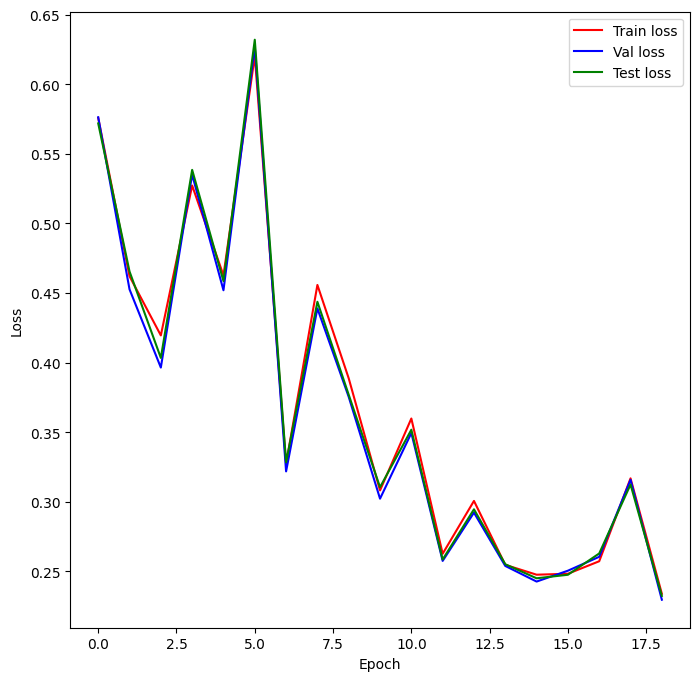

In [37]:
draw_loss_change(train_acc_list, val_acc_list, test_acc_list)

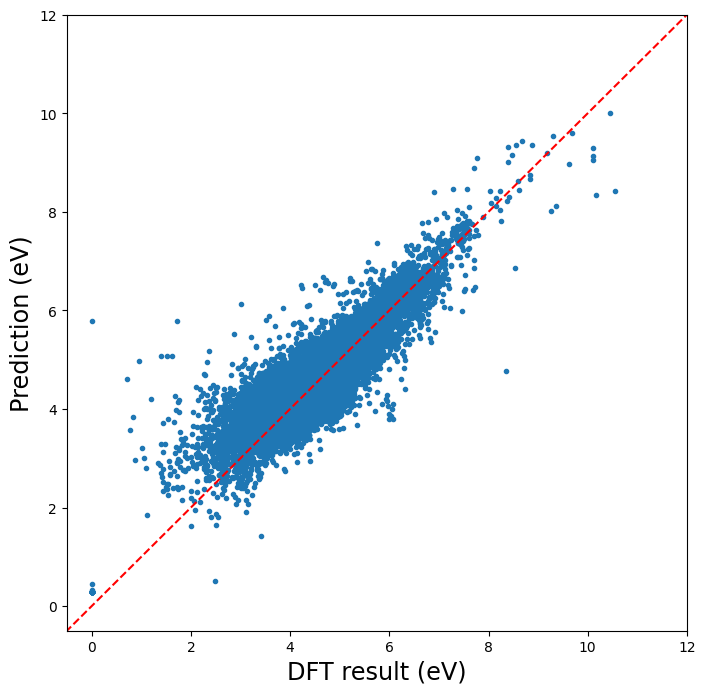

In [38]:
# parity plot
#out_all = [x.detach().numpy() for x in out_all]
dft = [x for x in true_all]
prediction = [x for x in out_all]

plt.figure(figsize=(8, 8))
plt.scatter(dft, prediction, marker = '.')
plt.plot(range(-1, 16), range(-1, 16), 'r--')
plt.xlabel("DFT result (eV)", fontsize='xx-large')
plt.ylabel("Prediction (eV)", fontsize='xx-large')
plt.xlim(-0.5, 12)
plt.ylim(-0.5, 12);

In [39]:
corr = np.corrcoef(dft, prediction)
print(corr)

[[1.        0.8816225]
 [0.8816225 1.       ]]


In [40]:
print(f"Pearson R: {corr[0,1]:.4f}")

Pearson R: 0.8816
